# 1. 注意力机制

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 生成数据集
# 训练集样本数量
n_train = 50
# 生成训练集特征x_train，范围为[0, 5)，并进行排序
x_train, _ = torch.sort(torch.rand(n_train) * 5)
# 定义函数f，用于生成标签y
def f(x):
    return 2 * torch.sin(x) + x**0.8
# 生成训练集标签y_train，并加上服从正态分布的噪声
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
# 生成测试集特征x_test，范围为[0, 5)，步长为0.1
x_test = torch.arange(0, 5, 0.1)
# 生成测试集的真实标签y_truth
y_truth = f(x_test)
# 计算测试集样本数量
n_test = len(x_test)
n_test

50

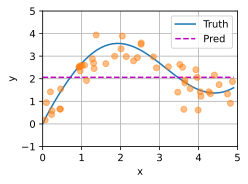

In [3]:
# 绘制核回归结果的图像
def plot_kernel_reg(y_hat):
    # 绘制x_test和对应的真实标签y_truth以及预测标签y_hat的图像
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth','Pred'],
            xlim=[0,5], ylim=[-1,5])
    # 绘制训练集的散点图，用圆圈表示
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)
# 将y_train的均值重复n_test次作为预测标签y_hat  
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
# 调用plot_kernel_reg函数，绘制核回归结果的图像
plot_kernel_reg(y_hat)

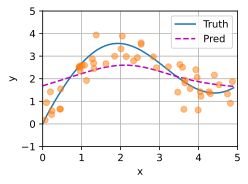

In [4]:
# 非参数注意力汇聚
# 将测试集特征x_test重复n_train次并重新reshape为二维矩阵
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# 计算注意力权重，通过对特征差值的平方取负并除以2，再进行softmax归一化
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)  
# 注意力权重与训练集标签y_train进行矩阵乘法得到预测标签y_hat
y_hat = torch.matmul(attention_weights, y_train)
# 调用plot_kernel_reg函数，绘制非参数注意力汇聚的核回归结果图像
plot_kernel_reg(y_hat)

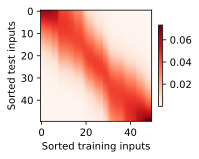

In [5]:
# 注意力权重
# 可视化注意力权重
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                xlabel='Sorted training inputs', ylabel='Sorted test inputs')   

In [6]:
# 带参数注意力汇聚
# 假定两个张量的形状分别是(n,a,b)和(n,b,c)，它们的批量矩阵乘法输出的形状为(n.a,c)  
# 创建形状为(2,1,4)的张量X，元素全为1
X = torch.ones((2,1,4))
# 创建形状为(2,4,6)的张量Y，元素全为1
Y = torch.ones((2,4,6))
# 执行批量矩阵乘法，并输出结果的形状
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [7]:
# 使用小批量矩阵乘法来计算小批量数据中的加权平均值
# 创建形状为(2,10)的权重张量，每个权重为0.1
weights = torch.ones((2,10)) * 0.1
# 创建形状为(2,10)的值张量，从0到19的连续数值
values = torch.arange(20.0).reshape((2,10))
# 执行小批量矩阵乘法，计算加权平均值
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [8]:
# 带参数的注意力汇聚
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # 创建形状为(1,)的参数张量w，用于调整注意力权重
        self.w = nn.Parameter(torch.rand((1,),requires_grad=True))  
        
    def forward(self, queries, keys, values):
        # 重复queries并调整形状，使其与keys具有相同的列数
        queries = queries.repeat_interleave(keys.shape[1]).reshape(-1,keys.shape[1])   
        # 计算注意力权重，通过调整参数w对注意力进行调节
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2/2,dim=1)     
        # 执行带参数的注意力汇聚，并返回最终结果的形状调整
        return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)   

In [9]:
# 将训练数据集转换为键和值
# 将x_train在行维度上重复n_train次，形成一个矩阵X_tile
X_tile = x_train.repeat((n_train, 1))
# 将y_train在行维度上重复n_train次，形成一个矩阵Y_tile
Y_tile = y_train.repeat((n_train, 1))
# 通过掩码操作，从X_tile中排除对角线元素，得到键矩阵keys
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))  
# 通过掩码操作，从Y_tile中排除对角线元素，得到值矩阵values
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(n_train, -1) 

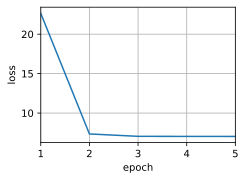

In [10]:
# 训练带参数的注意力汇聚模型
# 创建带参数的注意力汇聚模型
net = NWKernelRegression()
# 创建均方误差损失函数，用于计算损失
loss = nn.MSELoss(reduction='none')
# 创建随机梯度下降优化器，用于参数更新
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
# 创建动画绘制器，用于绘制损失曲线
animator = d2l.Animator(xlabel='epoch',ylabel='loss',xlim=[1,5])

# 遍历5次
for epoch in range(5):
    # 清零梯度
    trainer.zero_grad()
    # 计算损失
    l = loss(net(x_train, keys, values), y_train) / 2
    # 反向传播，计算梯度
    l.sum().backward()
    # 更新参数
    trainer.step()
    # 打印当前的损失
    print(f'epoch {epoch+1}, loss {float(l.sum()):.6f}')
    # 绘制损失曲线
    animator.add(epoch+1, float(l.sum()))

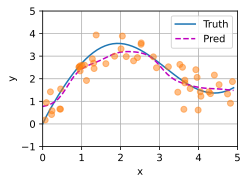

In [11]:
# 预测结果绘制
# 将训练数据集的输入在行维度上重复n_test次，形成键矩阵keys
keys = x_train.repeat((n_test, 1))
# 将训练数据集的输出在行维度上重复n_test次，形成值矩阵values
values = y_train.repeat((n_test, 1))
# 使用训练好的模型进行预测，得到预测结果y_hat
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
# 绘制预测结果
plot_kernel_reg(y_hat)

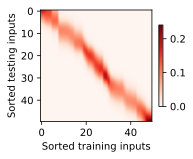

In [12]:
# 曲线在注意力权重较大的区域变得更不平滑
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                 xlabel='Sorted training inputs', ylabel='Sorted testing inputs')   